In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import metrics
import random
from sklearn import preprocessing
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
%matplotlib inline

 # I .  Function to load training and testing data

In [2]:
# function to load training and testing data
def load_train_and_test_data():
    train_features=pd.read_csv('TrainingSetValues.csv',parse_dates=True)
    train_labels=pd.read_csv('TrainingSetLabels.csv')
    to_predict_features=pd.read_csv('TestSetValues.csv',parse_dates=True)
    
    # merge training features and labels
    #training_data = pd.merge(train_features, train_labels, how='inner', on=['id'])
    
    return train_features, train_labels, to_predict_features

# II . FEATURE ENGINEERING FUNCTIONS

In [3]:
# impute median values for 0 amount_tsh
def impute_missing_amount_tsh(df):
    df.amount_tsh[df.amount_tsh <= 0] = np.median(df.amount_tsh[df.amount_tsh > 0])
    return df

In [4]:
# impute median values for 0 gps height
def impute_missing_gps_height(df):
    df.gps_height[df.gps_height <= 0] = np.median(df.gps_height[df.gps_height > 0])
    return df

In [5]:
# impute median values for 0 population
def impute_missing_population(df):
    df.population[df.population <= 0] = np.median(df.population[df.population > 0])
    return df

In [6]:
# transform population into categories
def label_population(row):
    if row['population'] <=0:
        return 'NA'
    elif row['population'] >= 1 and row['population'] <= 40:
        return 'A'
    elif row['population'] >= 41 and row['population'] <= 67:
        return 'B'
    elif row['population'] >= 68 and row['population'] <= 99:
        return 'C'
    elif row['population'] >= 100 and row['population'] <= 131:
        return 'D'
    elif row['population'] >= 132 and row['population'] <= 175:
        return 'E'
    elif row['population'] >= 176 and row['population'] <= 219:
        return 'F'
    elif row['population'] >= 220 and row['population'] <= 259:
        return 'G'
    elif row['population'] >= 260 and row['population'] <= 349:
        return 'H'
    elif row['population'] >= 350 and row['population'] <= 448:
        return 'I'
    elif row['population'] >= 449 and row['population'] <= 598:
        return 'J'
    elif row['population'] >= 599 and row['population'] <= 1290:
        return 'K'
    elif row['population'] >= 1291:
        return 'L'

def transform_population_into_categories(df):
    df['population_cat'] = df.apply(label_population, axis=1)
    return df

In [7]:
# impute median values for construction year
def impute_missing_construction_year(df):
    df.construction_year[df.construction_year <= 0] = np.median(df.construction_year[df.construction_year > 0])
    return df

In [8]:
# impute missing booleans with false and convert each value to float or integer
def impute_missing_booleans(df, colname):
    df[colname].fillna(False, inplace = True)
    df[colname] = df[colname].apply(lambda x: float(x))
    return df

date_recorded

In [9]:
# Since random forest doesnt work on datetime, we will break them down to month and year.
# But, also if we simply convert month into numerical values, it doesnt work well because 
# there may be big distance between Jan and December and also between 1970 to  2010, to take an example.
# So its better to one hot encode them after transforming the date to month and year
def transform_date_recorded_to_month_and_year(df):
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['year_recorded'] = df['date_recorded'].apply(lambda x: x.year)
    df['month_recorded'] = df['date_recorded'].apply(lambda x: x.month)
    df['date_recorded'] = (pd.to_datetime(df['date_recorded'])).apply(lambda x: x.toordinal())
    return df

# One Hot encode year and month recorded (first convert the month and year to string beafore OHEing)
# Also delete the original ones
def ohe_month_and_year_recorded(df_train, df_test):
    df_train = transform_date_recorded_to_month_and_year(df_train)
    df_test = transform_date_recorded_to_month_and_year(df_test)
    for col in ['month_recorded', 'year_recorded']:
        df_train[col] = df_train[col].apply(lambda x: str(x))
        df_test[col] = df_test[col].apply(lambda x: str(x))
        ohe_cols_postfix = [col + '_' + i for i in df_train[col].unique() if i in df_test[col].unique()]
        df_train = pd.concat((df_train, pd.get_dummies(df_train[col], prefix = col)[ohe_cols_postfix]), axis = 1)
        df_test = pd.concat((df_test, pd.get_dummies(df_test[col], prefix = col)[ohe_cols_postfix]), axis = 1)
        del df_test[col]
        del df_train[col]
    return df_train, df_test

In [10]:
# if latitude and/or lngitude is set to 0 or 1, it means that its a junk
# value. The latitude and longitude of Tanzania don't fall in this range
def cleanup_missing_latitude_and_longitude(df):
    df.loc[df.longitude == 0, 'latitude'] = 0
    df.loc[df.latitude == 1, 'longitude'] = 0
    
    df.loc[df.latitude == 0, 'longitude'] = 0
    df.loc[df.latitude == 1, 'longitude'] = 0
    
    return df

Drop columns function

In [11]:
# helper function to drop columns from a dataframe
# df is the dataframe from where we need to drop a column
# cols_to_drop is the list of column names that have to be dropped
def drop_columns(df, cols_to_drop):
    for col in cols_to_drop:
        del df[col]
    return df

In [15]:
# This function imputes missing/junk/illegal values in numerical columns with the mean of the respective 
# fields grouped by subvillage.
def fill_col_vals_with_col_mean_grp_by_subvilage(df_train, df_test, columns):
    for column in columns:
        df_train[column].replace(0., np.NaN, inplace = True)
        df_train[column].replace(1., np.NaN, inplace = True)
        df_test[column].replace(0., np.NaN, inplace = True)
        df_test[column].replace(1., np.NaN, inplace = True)
        
        df_train['mean'] = df_train.groupby(['subvillage'])[column].transform('mean')
        df_train[column] = df_train[column].fillna(df_train['mean'])
        o = df_train.groupby(['subvillage'])[column].mean()
        fill = pd.merge(df_test, pd.DataFrame(o), left_on=['subvillage'], right_index=True, how='left').iloc[:,-1]
        df_test[column] = df_test[column].fillna(fill)
        
        df_train[column] = df_train[column].fillna(df_train[column].mean())
        df_test[column] = df_test[column].fillna(df_train[column].mean())
        del df_train['mean']
    return df_train, df_test

One hot encode the categorical columns

In [16]:
# There are many columns that have many different values. Since our motive is to one hot encode the categorical columns,
# we need to reduce the no. of categories for each column. For this purpose we are putting together all the values that have 
# counts less than 100 as "other" category for each column that contains string values
def shrink_categories_for_columns(X_train, X_test):
    cols = [i for i in X_train.columns if type(X_train[i].iloc[0]) == str]
    #print(cols)
    #['funder', 'installer', 'wpt_name', 'basin', 'scheme_management', 'extraction_type', 
    # 'extraction_type_class', 'management', 'management_group', 'payment_type', 'water_quality', 
    #'quantity_group', 'source', 'source_class', 'waterpoint_type']
    X_train[cols] = X_train[cols].where(X_train[cols].apply(lambda x: x.map(x.value_counts())) > 100, "other")
    for column in cols:
        for i in X_test[column].unique():
            if i not in X_train[column].unique():
                X_test[column].replace(i, 'other', inplace=True)
    return X_train, X_test

Use LDA to reduce number of dimensions

In [17]:
# This function makes use of LDA to reduce the no. of dimensions. We will apply these on population, gps_height, latitude
# longitude because these have many different values and hence they are perfect candidates
def reduce_dimensions_using_lda(X_train, X_test, y_train, cols=['population', 'gps_height', 'latitude', 'longitude']):
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train[cols])
    X_test_std = sc.transform(X_test[cols])
    lda = LDA(n_components=None)
    X_train_lda = lda.fit_transform(X_train_std, y_train.values.ravel())
    X_test_lda = lda.transform(X_test_std)
    X_train = pd.concat((pd.DataFrame(X_train_lda), X_train), axis=1)
    X_test = pd.concat((pd.DataFrame(X_test_lda), X_test), axis=1)
    for i in cols:
        del X_train[i]
        del X_test[i]
    return X_train, X_test

Function for dummy-encoding i.e. one-hot-encoding of categorical columns

In [18]:
# function for dummy-encoding i.e. ne-hot-encoding of categorical columns
def one_hot_encode(df_train, df_test):
    columns = [i for i in df_train.columns if type(df_train[i].iloc[0]) == str]
    for column in columns:
        df_train[column].fillna('NULL', inplace = True)
        ohe_cols = [column+'_'+i for i in df_train[column].unique() if i in df_test[column].unique()]
        df_train = pd.concat((df_train, pd.get_dummies(df_train[column], prefix = column)[ohe_cols]), axis = 1)
        df_test = pd.concat((df_test, pd.get_dummies(df_test[column], prefix = column)[ohe_cols]), axis = 1)
        del df_train[column]
        del df_test[column]
    return df_train, df_test

# III. Variables and Data Set Analysis

Data analysis

In [19]:
# A quick and dirty data analysis
def do_some_data_analysis(training_data, training_labels):
    # find unique labels
    unique_labels = training_labels['status_group'].unique()
    unique_labels.sort()
    print("Unique labels are:", unique_labels)
    
    # find the count of each unique labels
    unique_labels_cnt = []
    cnt = training_labels[training_labels['status_group']=='functional']['status_group'].count()
    unique_labels_cnt.append(cnt)
    cnt = training_labels[training_labels['status_group']=='functional needs repair']['status_group'].count()
    unique_labels_cnt.append(cnt)
    cnt = training_labels[training_labels['status_group']=='non functional']['status_group'].count()
    unique_labels_cnt.append(cnt)
    #unique_labels_count.
    print("count of each type of pump(functional/functional-needs-repair/non functional)")
    print(unique_labels_cnt)
    y_pos = np.arange(len(unique_labels))
    plt.bar(y_pos, unique_labels_cnt, align='center', alpha=0.5)
    plt.xticks(y_pos, unique_labels)
    plt.ylabel('Count')
    plt.title('Distribution of status of pumps') 
    plt.show()
    
    # year-wise distribution of pumps in different conditions
#   training_data.construction_year=pd.to_numeric(training_data.construction_year)
#   training_data.loc[training_data.construction_year <= 0, training_data.columns=='construction_year'] = 1950
#   hist1=training_data[training_data.status_group == 'functional'].construction_year
#   hist2=training_data[training_data.status_group == 'functional needs repair'].construction_year
#   hist3=training_data[training_data.status_group == 'non functional'].construction_year
#   n,b,p=plt.hist([hist1, hist2, hist3], stacked=True,range=[1950,2010])
#   plt.legend(['functional', 'functional needs repair','non functional'],loc=0)
#   plt.text(1952, 15000,'NO DATA',fontsize=20,rotation=90,color='white')
#   plt.xlabel('Construction Year', fontsize=18)
#   plt.show()

Helper function for column values analysis

In [20]:
# Helper function for column values analysis
def analyze_unique_values_for_column(df, colname):
    unique_col_vals = df[colname].unique()
    tmp_str = "Unique " + colname + "s:"
    print("****************************")
    print(tmp_str, unique_col_vals.size)
    print("****************************")

Helper function for column values analysis.

In [21]:
# Helper function for column values analysis. This function helped us in detailed analysis for the purpose of feature
# engineering and helped us in finding out what function to keep/ what too drop/ what values to put under one single category
# and so on.
def analyze_in_detail_unique_values_for_column(df, colname):
    unique_col_vals = df[colname].unique()
    tmp_str = "Unique " + colname + "s:"
    print("****************************")
    print(tmp_str, unique_col_vals.size)
    print("****************************")
    lessthan10 = 0
    lessthan20 = 0
    lessthan30 = 0
    lessthan50 = 0
    lessthan100 = 0
    for val in unique_col_vals:
        cnt = df[df[colname] == val][colname].count()
        print(val, cnt) # uncomment this line if you want to see the count of each colname-value
        if(cnt < 10):
            lessthan10 +=1     
            print(val, cnt)
        elif(cnt < 20):
            lessthan20 +=1
        elif(cnt < 30):
            lessthan30 +=1
        elif(cnt < 50):
            lessthan50 +=1

    print("lessthan50: ", lessthan50 )
    print("lessthan30: ", lessthan30 )
    print("lessthan20: ", lessthan20 )
    print("lessthan10: ", lessthan10 )
    print("****************************")

Load the traiing and testing(to be predicted) data

In [22]:
# load the training and testing(to be predcicted) data
df_training_data, df_training_labels, df_topredict_data = load_train_and_test_data()

Analysis about the no. of functional/needs-repair/non-functional pumps

Unique labels are: ['functional' 'functional needs repair' 'non functional']
count of each type of pump(functional/functional-needs-repair/non functional)
[32259, 4317, 22824]


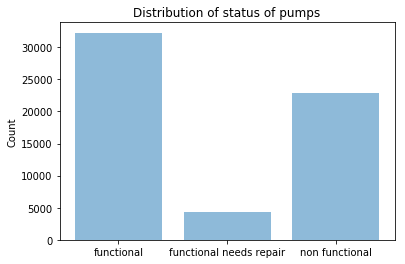

In [23]:
# some quick analysis about the no. of functional/needs-repair/non-functional pumps
do_some_data_analysis(df_training_data, df_training_labels)

In [24]:
# Keep a copy of the "to be predicted data" from where we can extract the id for the submission file
df_to_predict_data1 = df_topredict_data

Variables Status

In [25]:
print("*****************************************\nBrief Stats of each column\n*****************************************")
print(df_training_data.describe())

*****************************************
Brief Stats of each column
*****************************************
                 id     amount_tsh    gps_height     longitude      latitude  \
count  59400.000000   59400.000000  59400.000000  59400.000000  5.940000e+04   
mean   37115.131768     317.650385    668.297239     34.077427 -5.706033e+00   
std    21453.128371    2997.574558    693.116350      6.567432  2.946019e+00   
min        0.000000       0.000000    -90.000000      0.000000 -1.164944e+01   
25%    18519.750000       0.000000      0.000000     33.090347 -8.540621e+00   
50%    37061.500000       0.000000    369.000000     34.908743 -5.021597e+00   
75%    55656.500000      20.000000   1319.250000     37.178387 -3.326156e+00   
max    74247.000000  350000.000000   2770.000000     40.345193 -2.000000e-08   

        num_private   region_code  district_code    population  \
count  59400.000000  59400.000000   59400.000000  59400.000000   
mean       0.474141     15.297003   

How many not null/Zero in each variable/column?

In [26]:
#getting number of nonzeros in each column
print("\n*****************************************\nnumber of nonzeros in each column\n*****************************************")
print(df_training_data.astype(bool).sum(axis=0))


*****************************************
number of nonzeros in each column
*****************************************
id                       59399
amount_tsh               17761
date_recorded            59400
funder                   59400
gps_height               38962
installer                59400
longitude                57588
latitude                 59400
wpt_name                 59400
num_private                757
basin                    59400
subvillage               59400
region                   59400
region_code              59400
district_code            59377
lga                      59400
ward                     59400
population               38019
public_meeting           54345
recorded_by              59400
scheme_management        59400
scheme_name              59400
permit                   41908
construction_year        38691
extraction_type          59400
extraction_type_group    59400
extraction_type_class    59400
management               59400
management_gr

no. of nulls in each column

In [27]:
# getting no. of nulls in each column
print("\n*****************************************\nno. of nulls in each column\n*****************************************")
print(df_training_data.isnull().sum())


*****************************************
no. of nulls in each column
*****************************************
id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group   

In [28]:
# function to briefly analyze each column
def briefly_analyze_each_column(df_training_data):
    analyze_unique_values_for_column(df_training_data, "funder")
    analyze_unique_values_for_column(df_training_data, "installer")
    analyze_unique_values_for_column(df_training_data, "wpt_name")
    analyze_unique_values_for_column(df_training_data, "basin")
    analyze_unique_values_for_column(df_training_data, "subvillage")
    analyze_unique_values_for_column(df_training_data, "region")
    analyze_unique_values_for_column(df_training_data, "region_code")
    analyze_unique_values_for_column(df_training_data, "district_code")
    analyze_unique_values_for_column(df_training_data, "lga")
    analyze_unique_values_for_column(df_training_data, "ward")
    analyze_unique_values_for_column(df_training_data, "recorded_by")
    analyze_unique_values_for_column(df_training_data, "scheme_management")
    analyze_unique_values_for_column(df_training_data, "scheme_name")
    analyze_unique_values_for_column(df_training_data, "extraction_type")
    analyze_unique_values_for_column(df_training_data, "extraction_type_group")
    analyze_unique_values_for_column(df_training_data, "extraction_type_class")
    analyze_unique_values_for_column(df_training_data, "management")
    analyze_unique_values_for_column(df_training_data, "management_group")
    analyze_unique_values_for_column(df_training_data, "management_group")
    analyze_unique_values_for_column(df_training_data, "payment")
    analyze_unique_values_for_column(df_training_data, "payment_type")
    analyze_unique_values_for_column(df_training_data, "management_group")
    analyze_unique_values_for_column(df_training_data, "water_quality")
    analyze_unique_values_for_column(df_training_data, "quality_group")
    analyze_unique_values_for_column(df_training_data, "quantity")
    analyze_unique_values_for_column(df_training_data, "quantity_group")
    analyze_unique_values_for_column(df_training_data, "source")
    analyze_unique_values_for_column(df_training_data, "source_type")
    analyze_unique_values_for_column(df_training_data, "source_class")
    analyze_unique_values_for_column(df_training_data, "source_class")
    analyze_unique_values_for_column(df_training_data, "waterpoint_type")
    analyze_unique_values_for_column(df_training_data, "waterpoint_type_group")


uncomment the following function if we need to analyze the columns in brief

In [29]:
#briefly_analyze_each_column(df_training_data)

The next few function calls help us do a detailed analysis of each column

In [30]:
analyze_in_detail_unique_values_for_column(df_training_data, "funder")

****************************
Unique funders: 1898
****************************
Roman 275
Grumeti 53
Lottery Club 8
Lottery Club 8
Unicef 1057
Action In A 1
Action In A 1
Mkinga Distric Coun 150
Dwsp 811
Rwssp 1374
Wateraid 333
Isingiro Ho 14
Private 295
Danida 3114
World Vision 1246
Lawatefuka Water Supply 180
Biore 31
Rudep 312
Hesawa 2202
Twe 97
Isf 316
African Development Bank 35
Government Of Tanzania 9084
Sobodo 1
Sobodo 1
Water 583
Private Individual 826
Undp 86
nan 0
nan 0
Not Known 27
Kirde 54
Cefa 67
Ces(gmbh) 260
European Union 48
Lga 442
District Council 843
Muwsa 107
Dwe/norad 50
Kkkt_makwale 166
Sawaka 2
Sawaka 2
Ces (gmbh) 165
Olgilai Village Community 14
Kkkt 1287
Roman Catholic 121
Norad 765
Adra 263
Sema 50
Piusi 1
Piusi 1
Dwe 484
Rc Church 321
Swisland/ Mount Meru Flowers 21
Ifad 27
Swedish 131
Idc 92
He 125
Isf/tacare 14
Jica 259
Mzee Sh 1
Mzee Sh 1
Aict 85
Tcrs 602
Kiuma 32
Germany Republi 610
Netherlands 470
Ruthe 16
Tulawaka Gold Mine 5
Tulawaka Gold Mine 5
Nethal

Tlc/thimotheo Masunga 1
Tlc/thimotheo Masunga 1
Dak 11
Kidep 29
Ubalozi Wa Marekani 18
Dmk Anglican 1
Dmk Anglican 1
Franc 13
Ka 39
Mgm 5
Mgm 5
Aimgold 9
Aimgold 9
Mzee Omari 2
Mzee Omari 2
Petro Patrice 1
Petro Patrice 1
Camartec 1
Camartec 1
Loliondo Secondary 4
Loliondo Secondary 4
Islamic Agency Tanzania 2
Islamic Agency Tanzania 2
Tanz Egypt Technical Cooper 3
Tanz Egypt Technical Cooper 3
Safari Roya 5
Safari Roya 5
Koica 9
Koica 9
Rdc 16
Total Land Care 25
Pad 4
Pad 4
Msf 20
Mamad 14
Padep 69
One Un 18
Fabia 1
Fabia 1
Lake Tanganyika 3
Lake Tanganyika 3
Italy 2
Italy 2
Solar Villa 2
Solar Villa 2
Roman Church 14
Singasinga 2
Singasinga 2
Rc/mission 5
Rc/mission 5
In 6
In 6
Adp Mombo 14
Pci 9
Pci 9
Norad/ Tassaf Ii 2
Norad/ Tassaf Ii 2
I Wash 27
Bs 7
Bs 7
Kambi Migoko 2
Kambi Migoko 2
Ai 12
Sauwasa 7
Sauwasa 7
Icdp 1
Icdp 1
Rotte 3
Rotte 3
Dhv/gove 10
Kmcl 10
Ccps 1
Ccps 1
Si 34
Rundu Man 8
Rundu Man 8
Serikari 3
Serikari 3
Undp/aict 13
Hdv 1
Hdv 1
Halmashauri 27
Concern /govern 

Mtc 2
Mtc 2
Lungwe 1
Lungwe 1
Dhinu 3
Dhinu 3
Aic Kij 1
Aic Kij 1
Mataro 2
Mataro 2
Dagida 1
Dagida 1
Redap 2
Redap 2
Nwssp 2
Nwssp 2
Lench 4
Lench 4
Wanakijiji 1
Wanakijiji 1
Nk 8
Nk 8
Nimrodi Mkono[mb] 1
Nimrodi Mkono[mb] 1
Maro 2
Maro 2
Professor Ben Ohio University 8
Professor Ben Ohio University 8
Rafael Michael 1
Rafael Michael 1
Tdrs 1
Tdrs 1
Bra 1
Bra 1
Suwasa 10
Twig 1
Twig 1
Tanzania Egypt Technical Co Op 1
Tanzania Egypt Technical Co Op 1
Lifetime 12
Comunedi Roma 1
Comunedi Roma 1
Unhcr/danida 1
Unhcr/danida 1
Bread Of The Worl 1
Bread Of The Worl 1
Lutheran 4
Lutheran 4
Tasf 1
Tasf 1
Rc Cathoric 4
Rc Cathoric 4
Halmashauri Wil 2
Halmashauri Wil 2
Mgaya 1
Mgaya 1
Grail Mission Kiseki Bar 1
Grail Mission Kiseki Bar 1
Answeer Muslim Grou 1
Answeer Muslim Grou 1
John Gileth 1
John Gileth 1
Care/dwe 1
Care/dwe 1
Liuwassa 3
Liuwassa 3
Ustawi 3
Ustawi 3
Nssf 1
Nssf 1
Kilol 1
Kilol 1
Nado 10
Judge Mchome 2
Judge Mchome 2
Minis 4
Minis 4
Milenia 8
Milenia 8
Water User Group 9
Water

Udc/sema 3
Misana George 1
Misana George 1
Csf 1
Csf 1
Moyowosi Basin 1
Moyowosi Basin 1
Isnashia And 1
Isnashia And 1
Hasnein Muij Mbunge 1
Hasnein Muij Mbunge 1
Mama Ku 1
Mama Ku 1
Afric 1
Afric 1
Kfw 2
Kfw 2
Ripati 1
Ripati 1
Iado 1
Iado 1
Bgss 1
Bgss 1
Stp-sustainable Tan 1
Stp-sustainable Tan 1
Dmdd/solider 1
Dmdd/solider 1
Team Rafiki 1
Team Rafiki 1
In Memoria Di Albeto 1
In Memoria Di Albeto 1
Tag Patmo's 2
Tag Patmo's 2
Halimashau 1
Halimashau 1
Norplan 1
Norplan 1
Lidep 3
Lidep 3
Drdp 1
Drdp 1
Kibo 2
Kibo 2
O 1
O 1
Abc-ihushi Development Cent 1
Abc-ihushi Development Cent 1
Ur 1
Ur 1
Oak'zion' And Bugango B' Commu 1
Oak'zion' And Bugango B' Commu 1
Costantine Herman 1
Costantine Herman 1
Yaole 1
Yaole 1
Ruangwa Lga 1
Ruangwa Lga 1
Kenyans Company 1
Kenyans Company 1
Kopwe Khalifa 1
Kopwe Khalifa 1
Wamissionari Wa Kikatoriki 1
Wamissionari Wa Kikatoriki 1
Kapelo 1
Kapelo 1
Water Authority 1
Water Authority 1
Tanz/egypt Technical  Co-op 1
Tanz/egypt Technical  Co-op 1
Fdc 1
Fdc

Buluga Subvillage Community 1
Buluga Subvillage Community 1
Lake Tanganyika Prodap 1
Lake Tanganyika Prodap 1
Kdpa 1
Kdpa 1
Nyamingu Subvillage 1
Nyamingu Subvillage 1
Ballo 1
Ballo 1
Fiwater 1
Fiwater 1
Mwelia Estate 3
Mwelia Estate 3
Sister Makulata 1
Sister Makulata 1
Veo 1
Veo 1
Qwick Win 1
Qwick Win 1
Matogoro 1
Matogoro 1
Rc Mi 1
Rc Mi 1
Luke Samaras Ltd 1
Luke Samaras Ltd 1
Icap 1
Icap 1
Winkyens 1
Winkyens 1
Deogratius Kasima 1
Deogratius Kasima 1
Muhindi 1
Muhindi 1
Sumriy 1
Sumriy 1
Kwang-nam Middle-school 1
Kwang-nam Middle-school 1
Samweli 1
Samweli 1
Waitaliano 1
Waitaliano 1
Robert Kampala 1
Robert Kampala 1
Tasaf/tlc 1
Tasaf/tlc 1
Mhina 1
Mhina 1
Cheni 3
Cheni 3
Crs 1
Crs 1
Tlc/jenus Malecha 1
Tlc/jenus Malecha 1
Prof. Saluati 1
Prof. Saluati 1
Uniceg 1
Uniceg 1
Morrovian 1
Morrovian 1
Tarangire Park 1
Tarangire Park 1
Pius Msekwa 1
Pius Msekwa 1
Dv 1
Dv 1
Worldvision 1
Worldvision 1
Rc Njoro 1
Rc Njoro 1
Kindoroko Water Project 1
Kindoroko Water Project 1
Birage 1
Birag

In [31]:
analyze_in_detail_unique_values_for_column(df_training_data, "installer")

****************************
Unique installers: 2146
****************************
Roman 94
GRUMETI 39
World vision 408
UNICEF 222
Artisan 135
DWE 17402
DWSP 192
Water Aid 48
Private 143
DANIDA 1050
Lawatefuka water sup 180
WEDECO 397
Danid 72
TWE 111
ISF 135
Kilolo Star 2
Kilolo Star 2
District council 392
Water 71
WU 301
nan 0
nan 0
Not known 17
Central government 622
CEFA 75
Commu 1060
Accra 30
World Vision 270
LGA 408
MUWSA 107
KKKT _ Konde and DWE 166
Government 1825
Olgilai village community 14
KKKT 898
RWE 1206
Adra /Community 55
SEMA 249
SHIPO 147
HESAWA 539
ACRA 278
Community 553
IFAD 25
Sengerema Water Department 214
HE 125
ISF and TACARE 1
ISF and TACARE 1
Kokeni 30
DA 84
Adra 80
ALLYS 1
ALLYS 1
AICT 84
KIUMA 32
CES 610
District Counci 13
Ruthe 16
Adra/Community 60
Tulawaka Gold Mine 5
Tulawaka Gold Mine 5
KKT C 5
KKT C 5
Hesawa 840
Water board 81
LOCAL CONTRACT 31
WFP 15
LIPS 2
LIPS 2
TASAF 396
World 121
0 777
SW 3
SW 3
Shipo 86
Fini water 133
Kanisa 6
Kanisa 6
OXFARM 96
VIL

Omari Mzee 1
Omari Mzee 1
Petro Patrice 1
Petro Patrice 1
Camartec 1
Camartec 1
Total land care 23
Wasso companies 4
Wasso companies 4
DASP 2
DASP 2
Islamic Agency Tanzania 2
Islamic Agency Tanzania 2
Tanz Egypt technical coopera 3
Tanz Egypt technical coopera 3
Village Govt 1
Village Govt 1
local technician 2
local technician 2
TAWASA 25
WATER  AID 10
AAR 4
AAR 4
MSF 15
Di 1
Di 1
Mackd 15
MAMAD 13
PADEP 29
Fabia 1
Fabia 1
CONCERN 22
ITALI 2
ITALI 2
Water aid/sema 2
Water aid/sema 2
Save the rain USA 21
Plan Tanzania 3
Plan Tanzania 3
Roman Church 14
Singasinga 3
Singasinga 3
RC/Mission 5
RC/Mission 5
In 3
In 3
V 1
V 1
Korogwe water works 23
PCI 8
PCI 8
Atlas 1
Atlas 1
DWE /TASSAF 1
DWE /TASSAF 1
Local te 52
World Division 2
World Division 2
Gwaseco 10
Kambi Migoko 1
Kambi Migoko 1
AI 11
SAUWASA 7
SAUWASA 7
Nyakilanganyi 1
Nyakilanganyi 1
DEE 4
DEE 4
MANYARA CONSTRUCTION 6
MANYARA CONSTRUCTION 6
Rotte 3
Rotte 3
KMCL 10
LINDALA CO 3
LINDALA CO 3
Government /Community 1
Government /Commu

MLAKI  CO 2
MLAKI  CO 2
Busoga trust 1
Busoga trust 1
mzee mabena 1
mzee mabena 1
NORAD/ 6
NORAD/ 6
BR 8
BR 8
local technitian 1
local technitian 1
Comunity 2
Comunity 2
Brad 1
Brad 1
Tanganyika Basin 2
Tanganyika Basin 2
MORNING CONSTRUCTION 1
MORNING CONSTRUCTION 1
Healt 9
Healt 9
Governme 2
Governme 2
Roma 2
Roma 2
KUMKUM 1
KUMKUM 1
PNR co 1
PNR co 1
Muslims 6
Muslims 6
Paffec 1
Paffec 1
Tansi 1
Tansi 1
CRAELIUS 1
CRAELIUS 1
APM 2
APM 2
Zao water spring X 1
Zao water spring X 1
TASA 2
TASA 2
CSPD 5
CSPD 5
CIPRO/CARE 3
CIPRO/CARE 3
DALDO 12
VIFAF 1
VIFAF 1
MTC 2
MTC 2
TCRS Kibondo 4
TCRS Kibondo 4
Howard and humfrey consultant 4
Howard and humfrey consultant 4
RUDEP/ 10
LUNGWE 1
LUNGWE 1
Dhinu 3
Dhinu 3
AIC KI 1
AIC KI 1
Mataro 2
Mataro 2
FINI Water 1
FINI Water 1
Mombo urban water 3
Mombo urban water 3
REDAP 2
REDAP 2
Kagulo 1
Kagulo 1
TMP 1
TMP 1
Nimrod Mkono[mb] 1
Nimrod Mkono[mb] 1
Red Cross 5
Red Cross 5
SHULE 7
SHULE 7
Maro 2
Maro 2
WEDEKO 2
WEDEKO 2
UN ONE 4
UN ONE 4
BRA 1
BRA

WA 1
WA 1
Insititutiona 1
Insititutiona 1
kanisa 1
kanisa 1
Colonial Government 2
Colonial Government 2
TUKWARE ENTERP 1
TUKWARE ENTERP 1
ANGRIKANA 7
ANGRIKANA 7
church 1
church 1
Anglican church 3
Anglican church 3
TASAFcitizen and LGA 1
TASAFcitizen and LGA 1
SHIP 2
SHIP 2
Zingibali Secondary 1
Zingibali Secondary 1
KAEM 1
KAEM 1
Tajiri Jumbe Lila 1
Tajiri Jumbe Lila 1
SAXON  BUILDING CONTRACTOR 1
SAXON  BUILDING CONTRACTOR 1
Ngelepo group 1
Ngelepo group 1
VILLAGERS 9
VILLAGERS 9
CARE 1
CARE 1
Nduku village 3
Nduku village 3
Amadi 1
Amadi 1
Jafary Mbaga 1
Jafary Mbaga 1
Sa 1
Sa 1
Water hu 1
Water hu 1
Luleka 1
Luleka 1
TLC/Seleman Mang'ombe 1
TLC/Seleman Mang'ombe 1
Lutheran Church 4
Lutheran Church 4
Railway 2
Railway 2
Laramatak 2
Laramatak 2
TASAF and MMEM 1
TASAF and MMEM 1
DSV 2
DSV 2
WUA 8
WUA 8
Saleh Zaharani 4
Saleh Zaharani 4
HESAWQ 1
HESAWQ 1
Action Contre la Faim 1
Action Contre la Faim 1
KIDIJAS 1
KIDIJAS 1
Mwalimu  Muhenzi 1
Mwalimu  Muhenzi 1
Mamaz 1
Mamaz 1
Heri missi

Kinga 1
Yohanis Mgaya 1
Yohanis Mgaya 1
HASHI 1
HASHI 1
Elina 1
Elina 1
CHRISTAN OUTRICH 1
CHRISTAN OUTRICH 1
NJOONJOO 1
NJOONJOO 1
RC Msufi 1
RC Msufi 1
Chacha 1
Chacha 1
PWD 1
PWD 1
Action Aid 1
Action Aid 1
lusajo 1
lusajo 1
Frida mokeki 1
Frida mokeki 1
Salum Tambalizeni 1
Salum Tambalizeni 1
Primo 1
Primo 1
VILLAGE WATER COMMISSION 1
VILLAGE WATER COMMISSION 1
villager 1
villager 1
Shingida yetu 1
Shingida yetu 1
TANCRO 1
TANCRO 1
TAIPO 1
TAIPO 1
Ilaramataki 1
Ilaramataki 1
TCRS TWESA 1
TCRS TWESA 1
Angrikana 1
Angrikana 1
HAIDOMU LUTHERAN CHURCH 1
HAIDOMU LUTHERAN CHURCH 1
Kibo potry 1
Kibo potry 1
FRESH WATER PLC ENGLAND 1
FRESH WATER PLC ENGLAND 1
Mashaka M 1
Mashaka M 1
Safe Rescue Ltd 1
Safe Rescue Ltd 1
Rhobi Wamburs 1
Rhobi Wamburs 1
Great Lakes 1
Great Lakes 1
Mketo 1
Mketo 1
LGQ 1
LGQ 1
UN Habitat 1
UN Habitat 1
Stephano Paulo 1
Stephano Paulo 1
BAPTIST CHURCH 1
BAPTIST CHURCH 1
SIMBA 1
SIMBA 1
kegocha 1
kegocha 1
Egypt Government 2
Egypt Government 2
Perusi Bhoke 1
Perus

In [32]:
#analyze_in_detail_unique_values_for_column(df_training_data, "wpt_name")

In [33]:
analyze_in_detail_unique_values_for_column(df_training_data, "management")

****************************
Unique managements: 12
****************************
vwc 40507
wug 6515
other 844
private operator 1971
water board 2933
wua 2535
company 685
water authority 904
parastatal 1768
unknown 561
other - school 99
trust 78
lessthan50:  0
lessthan30:  0
lessthan20:  0
lessthan10:  0
****************************


In [34]:
analyze_in_detail_unique_values_for_column(df_training_data, "management_group")

****************************
Unique management_groups: 5
****************************
user-group 52490
other 943
commercial 3638
parastatal 1768
unknown 561
lessthan50:  0
lessthan30:  0
lessthan20:  0
lessthan10:  0
****************************


In [35]:
analyze_in_detail_unique_values_for_column(df_training_data, "extraction_type_class")

****************************
Unique extraction_type_classs: 7
****************************
gravity 26780
submersible 6179
handpump 16456
other 6430
motorpump 2987
wind-powered 117
rope pump 451
lessthan50:  0
lessthan30:  0
lessthan20:  0
lessthan10:  0
****************************


# IV. FEATURE EGINEERING EXECUTION

In [36]:
# We dont need the id field in trainign labels, delete this
del df_training_labels['id']

In [37]:
# Break down the date_recorded into month and year and one hot encode them
# Since random forest doesnt work on datetime, we will break them down to month and year.
# But, also if we simply convert month into numerical values, it doesnt work well because 
# there may be big distance between Jan and December and also between 1970 to  2010, to take an example.
# So its better to one hot encode them after transforming the date to month and year
df_training_data, df_topredict_data = ohe_month_and_year_recorded(df_training_data, df_topredict_data)

In [38]:
# impute missing construction year with median construction year
df_training_data = impute_missing_construction_year(df_training_data)
df_topredict_data = impute_missing_construction_year(df_topredict_data)

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
# the fields public_meeting and permit are boolean, but there are many missing values 
# (3334 in public_meeting and 3056 in permit)
# impute these missing values with FALSE
df_training_data = impute_missing_booleans(df_training_data, "public_meeting")
df_topredict_data = impute_missing_booleans(df_topredict_data, "public_meeting")

df_training_data = impute_missing_booleans(df_training_data, "permit")
df_topredict_data = impute_missing_booleans(df_topredict_data, "permit")

In [40]:
# if latitude and/or lngitude is set to 0 or 1, it means that its a junk
# value. The latitude and longitude of Tanzania don't fall in this range
df_training_data = cleanup_missing_latitude_and_longitude(df_training_data)
df_topredict_data = cleanup_missing_latitude_and_longitude(df_topredict_data)

# fill in the nulls for ['longitude', 'latitude', 'gps_height'] by using the mean of the respective columns
# grouped by subvillage; subvillage has the highest granularity compared to region_code, district_code, ward, basin etc.
# We could also use the overalll mean, but more granularity is better
location_columns_to_clean = ['longitude', 'latitude', 'gps_height']
df_training_data, df_topredict_data = fill_col_vals_with_col_mean_grp_by_subvilage(df_training_data, df_topredict_data, location_columns_to_clean)

In [41]:
# if population field contains 0 or 1, it indiactes some junk value
# fill these with median values for those subvillages and after that log-transform them. 
#However, after log transformation, it was observed that there was no improvement in accuracy, but there was no harm either

location_columns_to_clean = ['population']
df_training_data, df_topredict_data = fill_col_vals_with_col_mean_grp_by_subvilage(df_training_data, df_topredict_data, location_columns_to_clean)
df_training_data['population'] = np.log(df_training_data['population'])
df_topredict_data['population'] = np.log(df_topredict_data['population'])

# V .FEATURE SELECTION

Drop unwanted columns 

We will drop the following columns because of the reasons mentioned below:
1. id - Not a feature 
2. amount_tsh - 
3. num_private - too many different values(approx 58000), so holds no significance
4. region - almost perfect correaltion with region_code
5. quantity - very strong correlation with quantity_group
6. quality_group - very strong correlation with water_quality
7. source_type - very strong correlation with source
8. water_point_group - very strong correlation with water_point_type
9. payment - very strong correlation with payment_type
10. extraction_type_group - strong correlation with extraction_type
11. recorded_by - same values in all the rows, so its not a discriminant
12. subvillage/district_code/lga/ward - all these denote region, as such we can drop these. region is already being represented by lat/long and also by region_code
13. scheme_name - 2697 different values and 28166 empty values; so this field is almost useless


In [42]:
# drop unwanted columns 
columns_to_drop = ['id','amount_tsh', 'num_private', 'region', 'quantity', 'quality_group', 'source_type', 'payment', 
'waterpoint_type_group', 'extraction_type_group', 'recorded_by', 'subvillage', 'district_code', 'lga', 'ward', 'scheme_name']
df_training_data = drop_columns(df_training_data, columns_to_drop)
df_topredict_data = drop_columns(df_topredict_data, columns_to_drop)

In [43]:
# There are many columns that have many different values. Since our motive is to one hot encode the categorical columns,
# we need to reduce the no. of categories for each column. For this purpose we are putting together all the values that have 
# counts less than 100 as "other" category for each column that contains string values
df_training_data, df_topredict_data = shrink_categories_for_columns(df_training_data, df_topredict_data)

In [44]:
# Make use of LDA to reduce the no. of dimensions
df_training_data, df_topredict_data = reduce_dimensions_using_lda(
    df_training_data, df_topredict_data, df_training_labels, cols = ['gps_height', 'latitude', 'longitude'])

In [45]:
# One hot encode the columns that have categorical values
df_training_data,df_topredict_data = one_hot_encode(df_training_data, df_topredict_data)
#df_topredict_data = one_hot_encode1(df_topredict_data)

In [46]:
# Check the final no. of columns on which RandomForestClassifier is going to run; just for diagnostic purposes
print(len(df_training_data.columns))

306


In [47]:
# The following 2 functions help us in hyperparameter tuning of RandomForestCalssifier fucntion(the variables such as)
# n_estimators, max_features, max_depth, criterion(gini/entropy), min_samples_split
# Using the output of this function we tuned the respective parameters for RandomForestClassifier

# function to evaluate the performance of a model
def evaluate_model_performance(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

# This function is used for finding the best suitable value for hyperparameter tuning.
def find_best_values_for_hyperparameters(X_train, y_train):
    rf = RandomForestClassifier(criterion='gini', max_features='auto', min_samples_split=6, 
                                oob_score=True, random_state=1, n_jobs=-1)

    #param_grid = {"n_estimators" : [500, 750, 1000], "min_samples_split" : [4, 6, 8]}

    param_grid = { 'n_estimators': [200, 500, 750, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [4,5,6,7,8],
        'criterion' :['gini', 'entropy'], 'min_samples_split' : [4, 6, 8] }

    gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1)

    gs = gs.fit(X_train, y_train)
    print(gs.best_score_)
    print(gs.best_params_)
    print(gs.grid_scores_)
    grid_accuracy = evaluate(best_grid, test_features, test_labels)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(df_training_data, df_training_labels, test_size = 0.25, random_state = 42)
## Create random forest classifier instance
## Train and Test dataset size details
print ("X_train Shape :: ", X_train.shape)
print ("y_train Shape :: ", y_train.shape)
print ("X_test Shape :: ", X_test.shape)
print ("y_test Shape :: ", y_test.shape)

# Uncomment this function for finding the best values for hyper-parameters
#find_best_values_for_hyperparameters(X_train, y_train)

rf = RandomForestClassifier(criterion='gini', min_samples_split=6, n_estimators=1000, max_features='auto', 
                            oob_score=True, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)

X_train Shape ::  (44550, 306)
y_train Shape ::  (44550, 1)
X_test Shape ::  (14850, 306)
y_test Shape ::  (14850, 1)


C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [49]:
print ("Train Accuracy :: ", accuracy_score(y_train, rf.predict(X_train)))
print ("Test Accuracy  :: ", accuracy_score(y_test, predictions))
print ("Confusion matrix ", confusion_matrix(y_test, predictions))

predictions = rf.predict(df_topredict_data)
df_predictions = pd.DataFrame(predictions)

# Output the predictions into a csv file
columns = ['id','status_group']
df_submission = pd.DataFrame(columns=columns)
df_to_predict_data1 = df_to_predict_data1.reset_index(drop=True)
df_predictions = df_predictions.reset_index(drop=True)
df_submission = df_submission.reset_index(drop=True)
df_submission['id'] = df_to_predict_data1['id']
df_submission['status_group'] = df_predictions[0]
df_submission.to_csv("submission_ab_kn_on_split_data.csv", sep=",", index = False)

Train Accuracy ::  0.932076318743
Test Accuracy  ::  0.804511784512
Confusion matrix  [[7249  158  691]
 [ 591  326  157]
 [1221   85 4372]]


In [50]:
#find_best_values_for_hyperparameters(df_training_data, df_training_labels.values.ravel())

# Random Forest Classifier 

In [51]:
# Train the random forest classifier with the whole of training data
rf = RandomForestClassifier(criterion='gini', min_samples_split=6, n_estimators=1000, max_features='auto',
     oob_score=True, random_state=1, n_jobs=-1)
rf.fit(df_training_data, df_training_labels.values.ravel())

# The accuracy score on training data
print ("%.4f" % rf.oob_score_)

0.8112


Value Prediction

In [52]:
# Predict the values for which we don't have the labels
predictions = rf.predict(df_topredict_data)

In [53]:
# convert the list of predicted values into dataframe
df_predictions = pd.DataFrame(predictions)
df_predictions

,0
0,non functional
1,functional
2,functional
3,non functional
4,functional
5,functional
6,functional
7,non functional
8,non functional
9,functional


# Output of the predictions in a csv file for the subsmission

In [54]:
# Output the predictions into a csv file
columns = ['id','status_group']
df_submission = pd.DataFrame(columns=columns)
#to_predict_features=pd.read_csv('TestSetValues.csv',parse_dates=True)
df_to_predict_data1 = df_to_predict_data1.reset_index(drop=True)
df_predictions = df_predictions.reset_index(drop=True)
df_submission = df_submission.reset_index(drop=True)
df_submission['id'] = df_to_predict_data1['id']
df_submission['status_group'] = df_predictions[0]
df_submission.to_csv("submission_ab_kn.csv", sep=",", index = False)

In [55]:
print(df_submission.shape)
print(df_submission.head)

(14850, 2)
<bound method NDFrame.head of           id             status_group
0      50785           non functional
1      51630               functional
2      17168               functional
3      45559           non functional
4      49871               functional
5      52449               functional
6      24806               functional
7      28965           non functional
8      36301           non functional
9      54122               functional
10       419               functional
11     45750           non functional
12       653           non functional
13     14017           non functional
14     44607               functional
15     40228               functional
16     27714               functional
17     28785           non functional
18     28330               functional
19     18532           non functional
20     69961               functional
21     55083           non functional
22      8691           non functional
23     30331           non functional
24     70